In [1]:
from alpha.notebook import *
from alpha.core.rsi_stats import rsiday, rsi30
from omicron.core.numpy_extensions import find_runs
await init_notebook()
from IPython.display import display
import asyncio
pd.options.display.max_rows = 999

In [2]:
df = await get_bars("600573", 80, '30m', '2021-11-02')
df[0]['frame']

datetime.datetime(2021, 10, 19, 10, 0, tzinfo=tzfile('/usr/share/zoneinfo/Asia/Shanghai'))

2021-11-03 16:18:58,057 W 9845 matplotlib.font_manager:_findfont_cached:1346 | findfont: Font family ['Microsoft YaHei', 'Heiti TC', 'Songti SC'] not found. Falling back to DejaVu Sans.


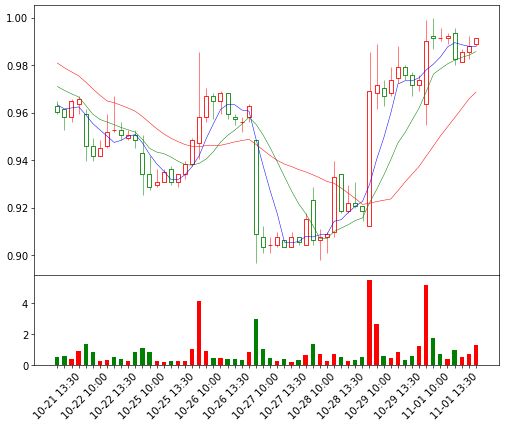

In [3]:
cs = Candlestick({"30m": [5,10,20]})
cs.plot_bars(df)

In [4]:
def momentum(bars, thres=1e-2):
    ma = moving_average(bars["close"], 5)
    
    w = len(bars) / 2
    h = w / 2
    plt.figure(figsize=(w, h))
    
    d2 = ma[1:]/ma[:-1] - 1
    #d2 = np.diff(d1)

    # align with d2
    ma = ma[1:]
    bars = bars[5:]
    close, frame = bars["close"], bars["frame"]
    
    #print(np.round(d2,2))
        
    isup, pos, length = find_runs(d2 >0)

    # 只保留变化显著的那些点
    valid_pos = pos[abs(d2[pos]) > thres]
    isup = isup[abs(d2[pos]) > thres]
    pos = valid_pos
    
    plt.plot(close, color='black')
    plt.plot(ma, color='c')
    
    up = pos[isup]
    down = pos[~isup]

    plt.plot(up, close[up] -0.02, 'r^')
    plt.plot(down, close[down]+0.02, 'gv')
    
    for x in pos:
        tm = str(frame[x]).split(" ")
        if len(tm) == 2: # it's time
            tm = tm[1][:-3]
        else:
            tm = tm[0][-5:]
            
        plt.text(x+0.05, close[x], f"{tm} {d2[x]:.03f}")
        
    trades = []
    gains = 1
    order = None
    
    for f, p in zip(isup, pos):
        if f and order is None:
            order = {
                "buy": close[p],
                "buy_at": frame[p]
            }
            
        elif (not f) and order:
            buy = order["buy"]
            sell = close[p]
            gain = sell / buy
            order.update({
                "sell": sell,
                "sell_at": frame[p],
                "gain": gain
            })
            
            gains *= gain
            trades.append(order)
            order = None
            
    return gains - 1, trades

In [7]:
results = await scan(momentum, 80, FrameType.MIN30, "2021-10-29 15:00", test=True)

In [10]:
results

[]